## Dogs v Cats super-charged!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
#Note: Enlarge the image is a good way to improve the result, if the size used to use is smaller than the average size be given
sz=299        
#Note: Another way to improve the result is to use more complex model.
#      I always use ResNext50 right after ResNet34 to get better result, but it will cost 2X longer than ResNet34, 
#      and 2~4X GPU memory than ResNet34, which result in smaller batch size as below to be able to fit the model into memory
arch=resnext50 
bs=16

#Note: I am running the same things as the lesson-1, expect these above settings

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.device_count()

4

In [5]:
torch.cuda.set_device(3)
torch.cuda.current_device()

3

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [7]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.050133   0.028798   0.993     



[0.028798411, 0.99299999999999999]

In [8]:
learn.precompute=False
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.04932    0.023428   0.994     
    1      0.063067   0.021288   0.994                                                                                 



[0.0212876, 0.99399999999999999]

In [9]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [10]:
# Note: Here I do not use cycle_mult is because as the resnext50 has much more parameters, it was overfitting pretty quickly.
#       If I use cycle_mult, I found val_loss was higher than trn_loss
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.052312   0.018444   0.994     
    1      0.052232   0.017441   0.994                                                                                 
    2      0.026278   0.017855   0.994                                                                                 



[0.017855279, 0.99399999999999999]

In [11]:
learn.save('224_all_50')

In [12]:
learn.load('224_all_50')

In [14]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.996

## Analyzing results

In [15]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[997   3]
 [  5 995]]


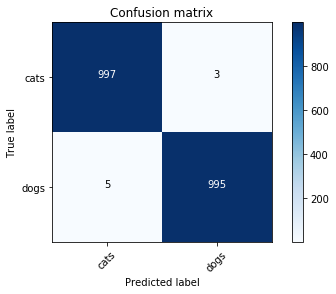

In [16]:
plot_confusion_matrix(cm, data.classes)

In [17]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


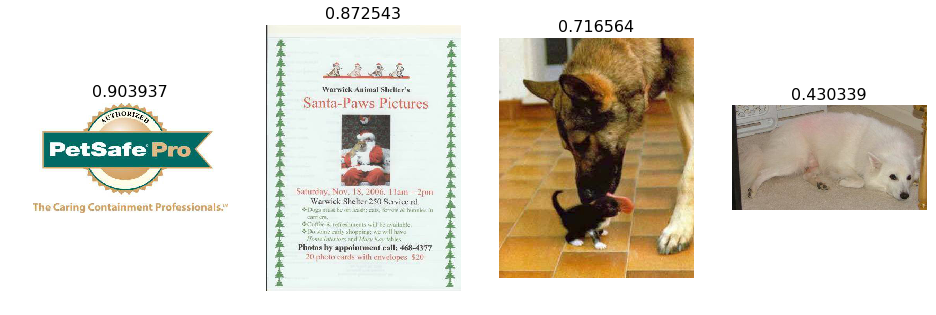

In [18]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


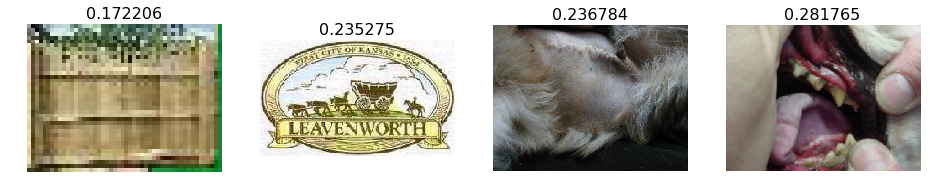

In [19]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")